Mounted at /content/drive
Using device: cpu
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


100%|██████████| 170M/170M [00:01<00:00, 152MB/s]


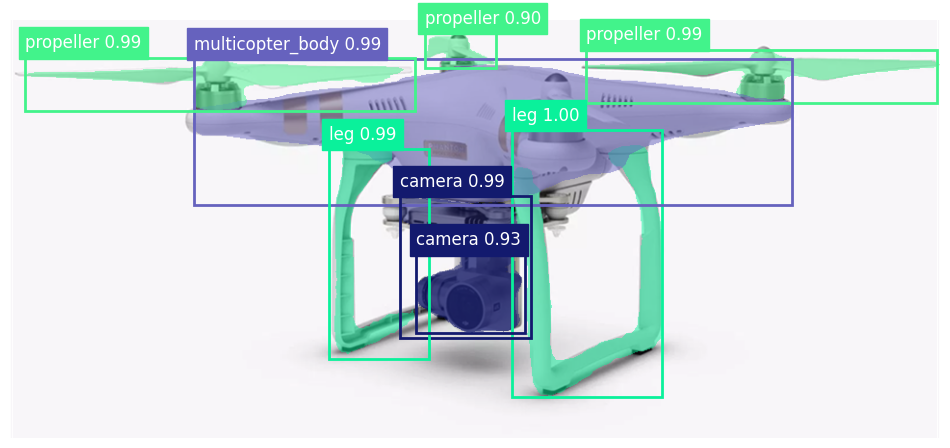

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms.functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

WEIGHTS_PATH = "/content/drive/MyDrive/mask_rcnn_checkpoints/latest.pth"
IMAGE_PATH = "/content/drive/MyDrive/test1.png"
CONFIDENCE_THRESHOLD = 0.7
CLASS_NAMES = [
    'background',
    'multicopter_body',
    'propeller',
    'camera',
    'leg'
]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

def get_model_instance_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn(weights="COCO_V1")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model


num_classes = len(CLASS_NAMES)
model = get_model_instance_segmentation(num_classes)
checkpoint = torch.load(WEIGHTS_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

img = Image.open(IMAGE_PATH).convert("RGB")
img_tensor = F.to_tensor(img).to(device)

with torch.no_grad():
    prediction = model([img_tensor])

img_np = np.array(img)
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img_np)

colors = np.random.uniform(0, 1, size=(num_classes, 3))

scores = prediction[0]['scores']
labels = prediction[0]['labels']
boxes = prediction[0]['boxes']
masks = prediction[0]['masks']

for i in range(len(scores)):
    score = scores[i].item()
    if score > CONFIDENCE_THRESHOLD:
        label_index = labels[i].item()
        class_name = CLASS_NAMES[label_index]
        color = colors[label_index]

        mask = masks[i, 0].cpu().numpy()
        for c in range(3):
            img_np[:, :, c] = np.where(mask > 0.5,
                                       img_np[:, :, c] * 0.5 + color[c] * 255 * 0.5,
                                       img_np[:, :, c])

        box = boxes[i].cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        ax.text(box[0], box[1] - 10, f"{class_name} {score:.2f}",
                color='white', backgroundcolor=color, fontsize=12)

ax.imshow(img_np)
plt.axis('off')
plt.show()